In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import argparse
import pandas as pd
import os.path as osp
import warnings
import numpy as np
import multiprocessing as mp
from sklearn.metrics import confusion_matrix

from ast import literal_eval
from plotly.offline import init_notebook_mode, iplot

from torchvision import models
import torchvision.transforms as transforms

from tqdm.notebook import tqdm as tqdm_notebook
from PIL import Image

init_notebook_mode()
%load_ext autoreload
%autoreload 2

In [2]:
img_dim = 256
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

In [3]:
def image_transformation(img_dim, lanczos=True):
    """simple transformation/pre-processing of image data."""

    if lanczos:
        resample_method = Image.LANCZOS
    else:
        resample_method = Image.BILINEAR

    normalize = transforms.Normalize(mean=image_net_mean, std=image_net_std)
    return transforms.Compose([transforms.Resize((img_dim, img_dim), resample_method),
                                  transforms.ToTensor(),
                                  normalize])

In [4]:
class ImageEmotionClassifier(nn.Module):
    def __init__(self, img_encoder, clf_head):
        super(ImageEmotionClassifier, self).__init__()
        self.img_encoder = img_encoder
        self.clf_head = clf_head

    def __call__(self, img):
        feat = self.img_encoder(img)
        logits = self.clf_head(feat)
        return logits

In [5]:
class MLP(nn.Module):
    """ Multi-near perceptron. That is a k-layer deep network where each layer is a fully-connected layer, with
    (optionally) batch-norm, a non-linearity and dropout. The last layer (output) is always a 'pure' linear function.
    """
    def __init__(self, in_feat_dims, out_channels, b_norm=True, dropout_rate=0,
                 non_linearity=nn.ReLU(inplace=True), closure=None):
        """Constructor
        :param in_feat_dims: input feature dimensions
        :param out_channels: list of ints describing each the number hidden/final neurons. The
        :param b_norm: True/False, or list of booleans
        :param dropout_rate: int, or list of int values
        :param non_linearity: nn.Module
        :param closure: optional nn.Module to use at the end of the MLP
        """
        super(MLP, self).__init__()
        self.hidden_dimensions = out_channels[:-1]
        self.embedding_dimension = out_channels[-1]

        n_layers = len(out_channels)
        dropout_rate = optional_repeat(dropout_rate, n_layers-1)
        b_norm = optional_repeat(b_norm, n_layers-1)

        previous_feat_dim = in_feat_dims
        all_ops = []

        for depth in range(len(out_channels)):
            out_dim = out_channels[depth]
            affine_op = nn.Linear(previous_feat_dim, out_dim, bias=True)
            all_ops.append(affine_op)

            if depth < len(out_channels) - 1:
                if b_norm[depth]:
                    all_ops.append(nn.BatchNorm1d(out_dim))

                if non_linearity is not None:
                    all_ops.append(non_linearity)

                if dropout_rate[depth] > 0:
                    all_ops.append(nn.Dropout(p=dropout_rate[depth]))

            previous_feat_dim = out_dim

        if closure is not None:
            all_ops.append(closure)

        self.net = nn.Sequential(*all_ops)

    def __call__(self, x):
        return self.net(x)

In [6]:
class ResnetEncoder(nn.Module):
    """Convenience wrapper around resnet models"""
    def __init__(self, backbone, adapt_image_size=None, drop=2, pretrained=True, verbose=False):
        """
        :param backbone: (string) resnet-S, S in [18, 34, 50, 101]
        :param adapt_image_size: (opt, int) if given forward feature has
            [B, adapt_image_size, adapt_image_size, feat-dim]
        :param drop: how many of the last layers/blocks to drop.
        :param pretrained: (Boolean)
        :param verbose: (opt, Boolean) if true print actions taken.
        Note: in total there are 10 layers/blocks. The last two are an adaptive_pooling and an FC, the
        previous layers give rise to convolutional maps of increasing spatial size.
        """

        if drop == 0 and adapt_image_size is not None:
            raise ValueError('Trying to apply adaptive pooling while keeping the entire model (drop=0).')

        super(ResnetEncoder, self).__init__()
        backbones = {
                'resnet18': models.resnet18,
                'resnet34': models.resnet34,
                'resnet50': models.resnet50,
                'resnet101': models.resnet101,
        }

        self.name = backbone
        self.drop = drop
        self.resnet = backbones[self.name](pretrained=pretrained)

        # Remove linear and last adaptive pool layer
        if drop > 0:
            modules = list(self.resnet.children())
            if verbose:
                print('Removing the last {} layers of a {}'.format(drop, self.name))
                print(modules[-drop:])
            modules = modules[:-drop]
            self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = None
        if adapt_image_size is not None:
            self.adaptive_pool = nn.AdaptiveAvgPool2d((adapt_image_size, adapt_image_size))

        if pretrained:
            for p in self.resnet.parameters():
                p.requires_grad = False

    def __call__(self, images):
        """Forward prop.
            :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
            :return: encoded images
        """
        out = self.resnet(images) # (B, F, ceil(image_size/32), ceil(image_size/32))

        if self.adaptive_pool is not None:
            out = self.adaptive_pool(out)  # (B, F, adapt_image_size, adapt_image_size)

        if self.drop > 0: # convolutional-like output
            out = out.permute(0, 2, 3, 1)      # bring feature-dim last.
            out = torch.squeeze(torch.squeeze(out, 1), 1)  # In case adapt_image_size == 1, remove dimensions
        return out

    def unfreeze(self, level=5, verbose=False):
        """Allow or prevent the computation of gradients for blocks after level.
        The smaller the level, the less pretrained the resnet will be.
        """
        all_layers = list(self.resnet.children())

        if verbose:
            ll = len(all_layers)
            print('From {} layers, you are unfreezing the last {}'.format(ll, ll-level))

        for c in all_layers[level:]:
            for p in c.parameters():
                p.requires_grad = True
        return self

    def embedding_dimension(self):
        """The feature (channel) dimension of the last layer"""
        if self.drop == 0:
            return 1000  #Imagenet Classes

        if self.drop == 2:
            return 512 if int(self.name.replace('resnet', '')) < 50 else 2048

        if self.drop == 3:
            return 256 if int(self.name.replace('resnet', '')) < 50 else 1024

        raise NotImplementedError

In [7]:
artemis_preprocessed_dir = 'data/preprocess_data/'
save_dir = 'data/models/img_to_emotion'  # for trained model
wikiart_img_dir = 'data/Wiki_Art'

checkpoint_file = osp.join(save_dir, 'artemis_resnet34.pt')
test_file = 'data/test/11_.jpg'

# minor parameters
GPU_ID = 0 

In [8]:
device = torch.device("cuda:" + str(GPU_ID) if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
ARTEMIS_EMOTIONS = ['amusement', 'awe', 'contentment', 'excitement',
                    'anger', 'disgust',  'fear', 'sadness', 'something else']

In [10]:
def torch_load_model(checkpoint_file, map_location=None):
    """ Wrap torch.load to catch standard warning of not finding the nested implementations.
    :param checkpoint_file:
    :param map_location:
    :return:
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = torch.load(checkpoint_file, map_location=map_location)
    return model

@torch.no_grad()
def test_on_dataset(model, file, img_transform):
    img = Image.open(file)
    display(img)
    img = img_transform(img)
    
    model.eval()
    img = img.to(device)
    img = img.unsqueeze(0)
    
    logits = model(img)[0].cpu()
    indices = np.argpartition(logits, -3)[-3:]
    emotions = [ARTEMIS_EMOTIONS[x] for x in indices]
    print(emotions)

C:\Users\김영래\AppData\Local\Temp\ipykernel_18720\3001550851.py:5: DeprecationWarning:

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.

C:\anaconda\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning:

Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.



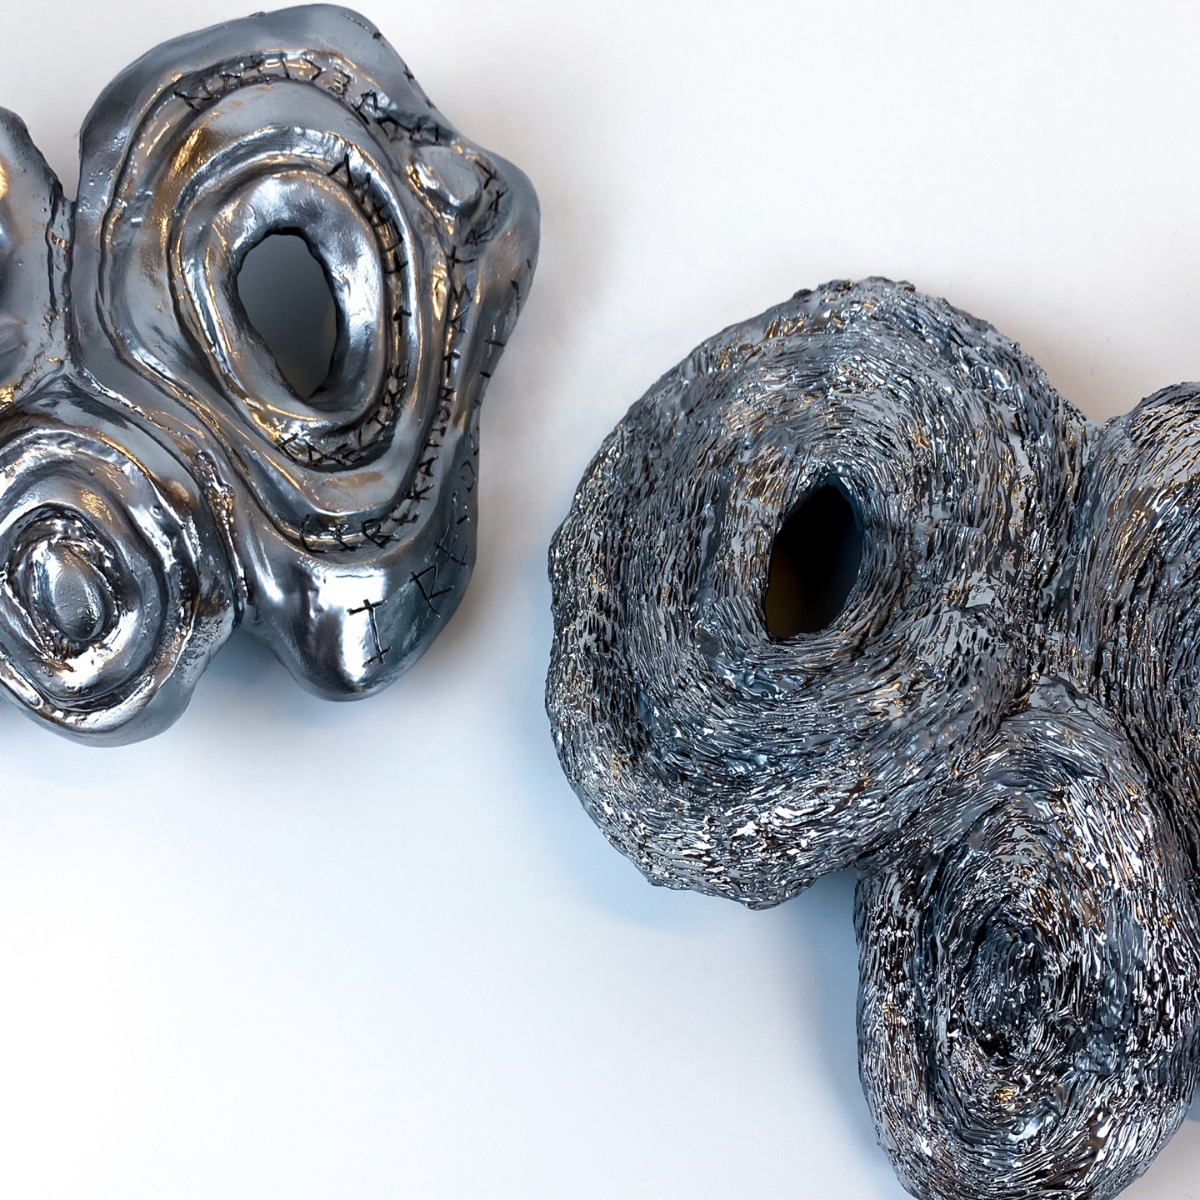

['awe', 'contentment', 'something else']


In [11]:
model = torch_load_model(checkpoint_file)    
test_on_dataset(model, test_file, image_transformation(img_dim))